In [1]:
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from sbi_lens.config import config_lsst_y_10

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
total_steps = 500_000
sbi_method = 'nle'
batch_size = 256
params_name = config_lsst_y_10.params_name_latex

In [10]:
if sbi_method == "npe":
    dataset = np.load(
            "gpfswork/rech/eqw/ufa23yn/ssnpe_desc_project/data/LOADED&COMPRESSED_year_10_with_noise_score_density.npz",
            allow_pickle=True,
        )["arr_0"]

elif sbi_method == "nle":
    dataset = np.load(
            "./LOADED&COMPRESSED_year_10_with_noise_score_conditional_very_large.npz",
            allow_pickle=True,
        )["arr_0"]


inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])
dataset_y = jnp.delete(dataset.item()["y"], inds, axis=0)
dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)
dataset_theta = jnp.delete(dataset.item()["theta"], inds, axis=0)

dataset_y_train = dataset_y[:len(dataset_score) // 2]
dataset_score_train = dataset_score[:len(dataset_score) // 2]
dataset_theta_train = dataset_theta[:len(dataset_score) // 2]

dataset_y_test = dataset_y[len(dataset_score) // 2:]
dataset_score_test = dataset_score[len(dataset_score) // 2:]
dataset_theta_test = dataset_theta[len(dataset_score) // 2:]

In [11]:
class MomentNetwork(hk.Module):
 
  def __call__(self, theta, y):
        
    net = jnp.concatenate([theta, y], axis = -1)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(6)(net)

    return net.squeeze()

In [12]:
get_moments = hk.without_apply_rng(hk.transform(lambda theta, y : MomentNetwork()(theta, y)))

# Predict esperance

In [13]:
@jax.jit
def loss_esperance(params, theta, y, score):

  out = get_moments.apply(params, theta, y)

  return jnp.sum((out - score) ** 2, axis=-1).mean() / 1000

@jax.jit
def update_esperance(params, opt_state, theta, y, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_esperance)(
        params, theta, y, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [14]:
rng_seq = hk.PRNGSequence(12)
params_esperance = get_moments.init(next(rng_seq), jnp.zeros([1, 6]), jnp.zeros([1, 6]))

nb_steps = total_steps - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-5,
    )

optimizer = optax.adam(lr_scheduler)
opt_state_esperance = optimizer.init(params_esperance)

batch_loss = []
val_loss = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
    inds = np.random.randint(0, len(dataset_score_train), batch_size)
    ex_score = dataset_score_train[inds]
    ex_theta = dataset_theta_train[inds]
    ex_y = dataset_y_train[inds]

    l, params_esperance, opt_state_esperance = update_esperance(
        params_esperance, opt_state_esperance, ex_theta, ex_y, ex_score
    )

    if batch % 500 == 0:
      batch_loss.append(l)
      val_loss.append(
          loss_esperance(
              params_esperance, 
              dataset_theta_test[inds], 
              dataset_y_test[inds],
              dataset_score_test[inds]
          )
      )
      lr_scheduler_store.append(lr_scheduler(batch))
      pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 207.918: 100%|██████████| 500001/500001 [05:39<00:00, 1472.28it/s]


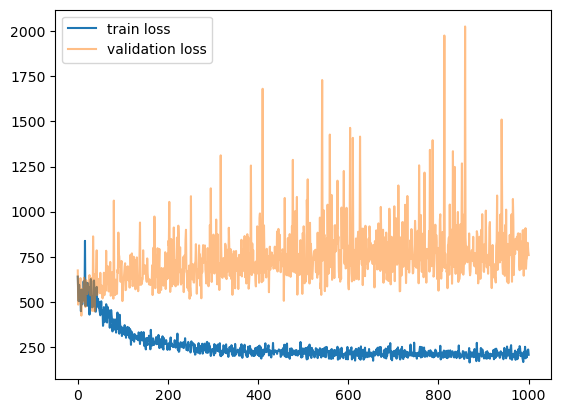

In [15]:
plt.plot(batch_loss, label = 'train loss')
plt.plot(val_loss, alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss.png")

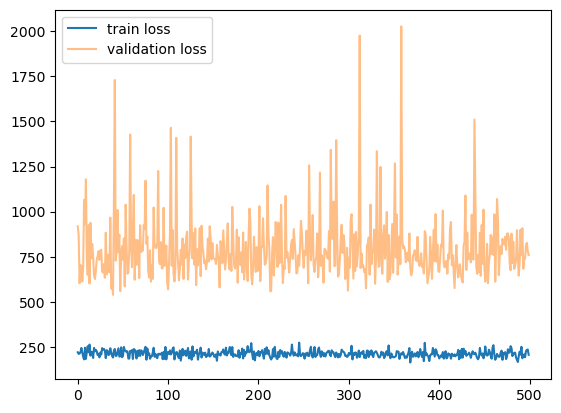

In [16]:
plt.plot(batch_loss[-500:], label = 'train loss')
plt.plot(val_loss[-500:], alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_zoom.png")

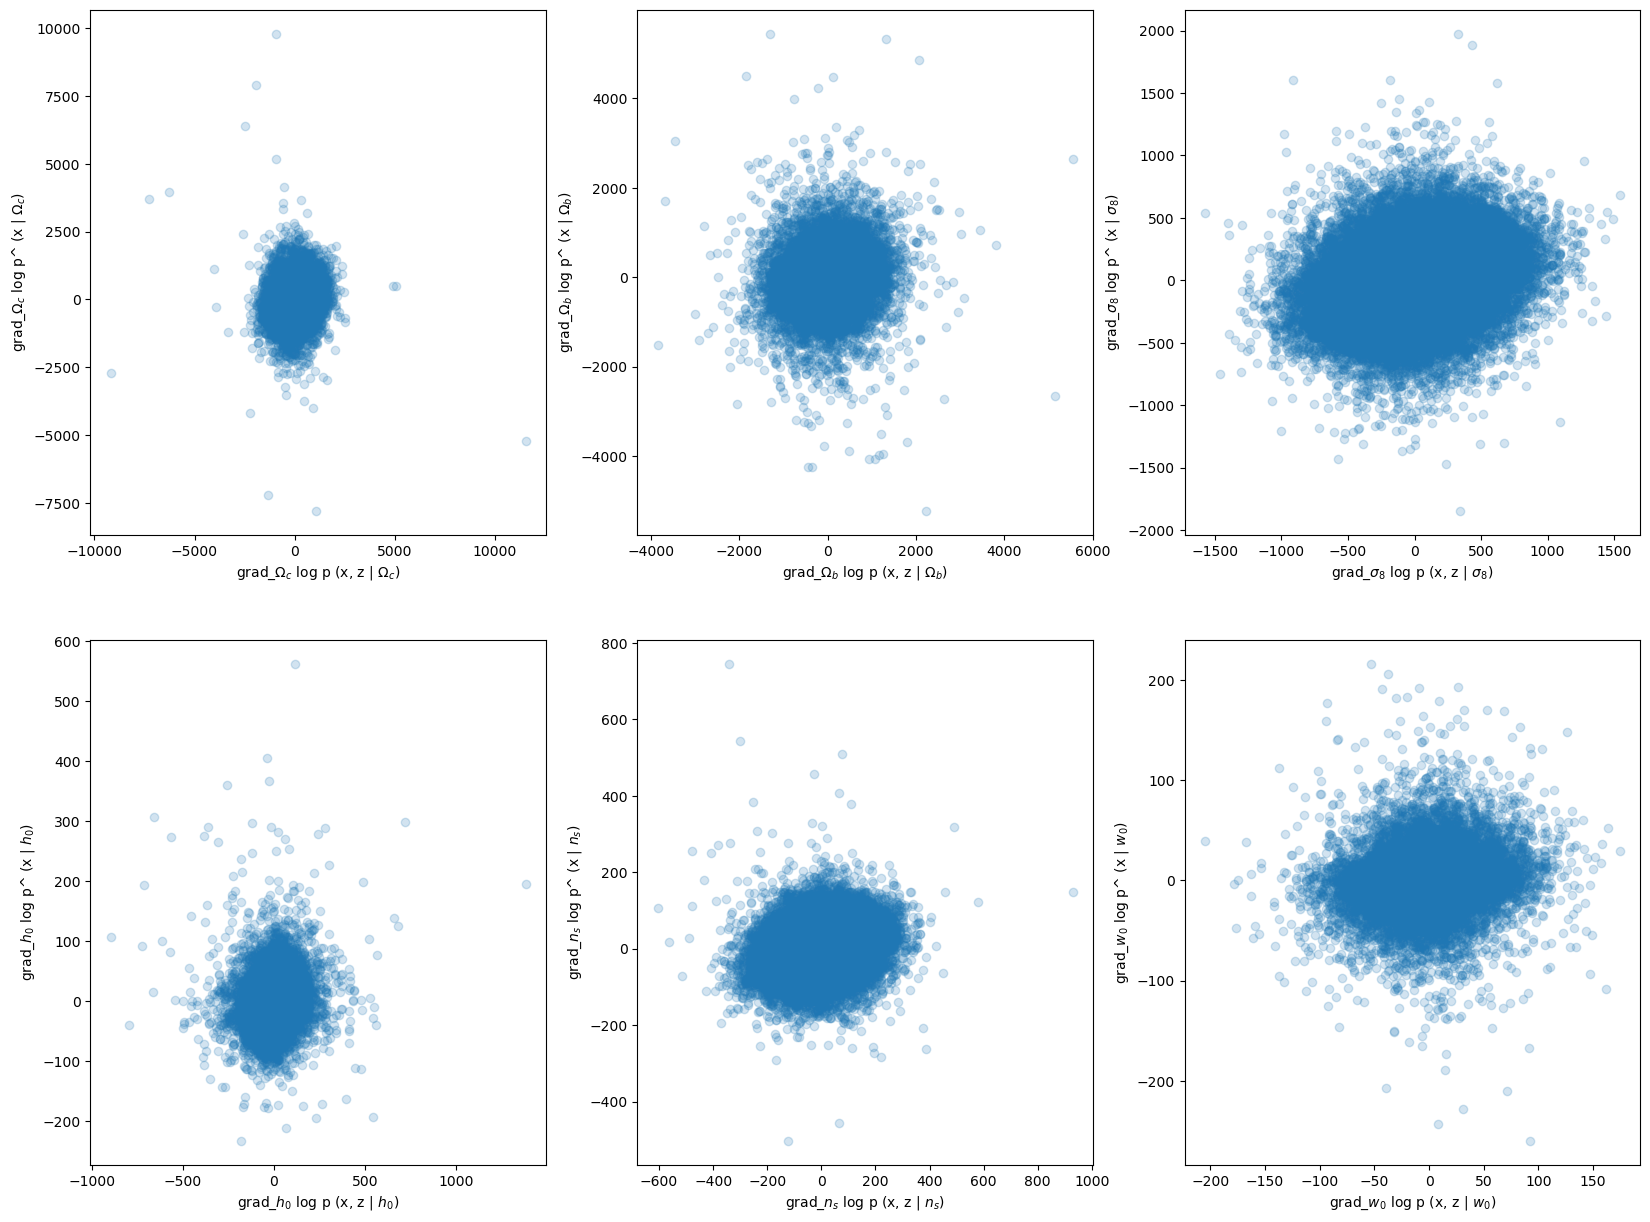

In [17]:
# check regression on test set

prediction = get_moments.apply(
    params_esperance,  
    dataset_theta_test,
    dataset_y_test
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_test[...,i], prediction[...,i], alpha = 0.2)
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression.png")

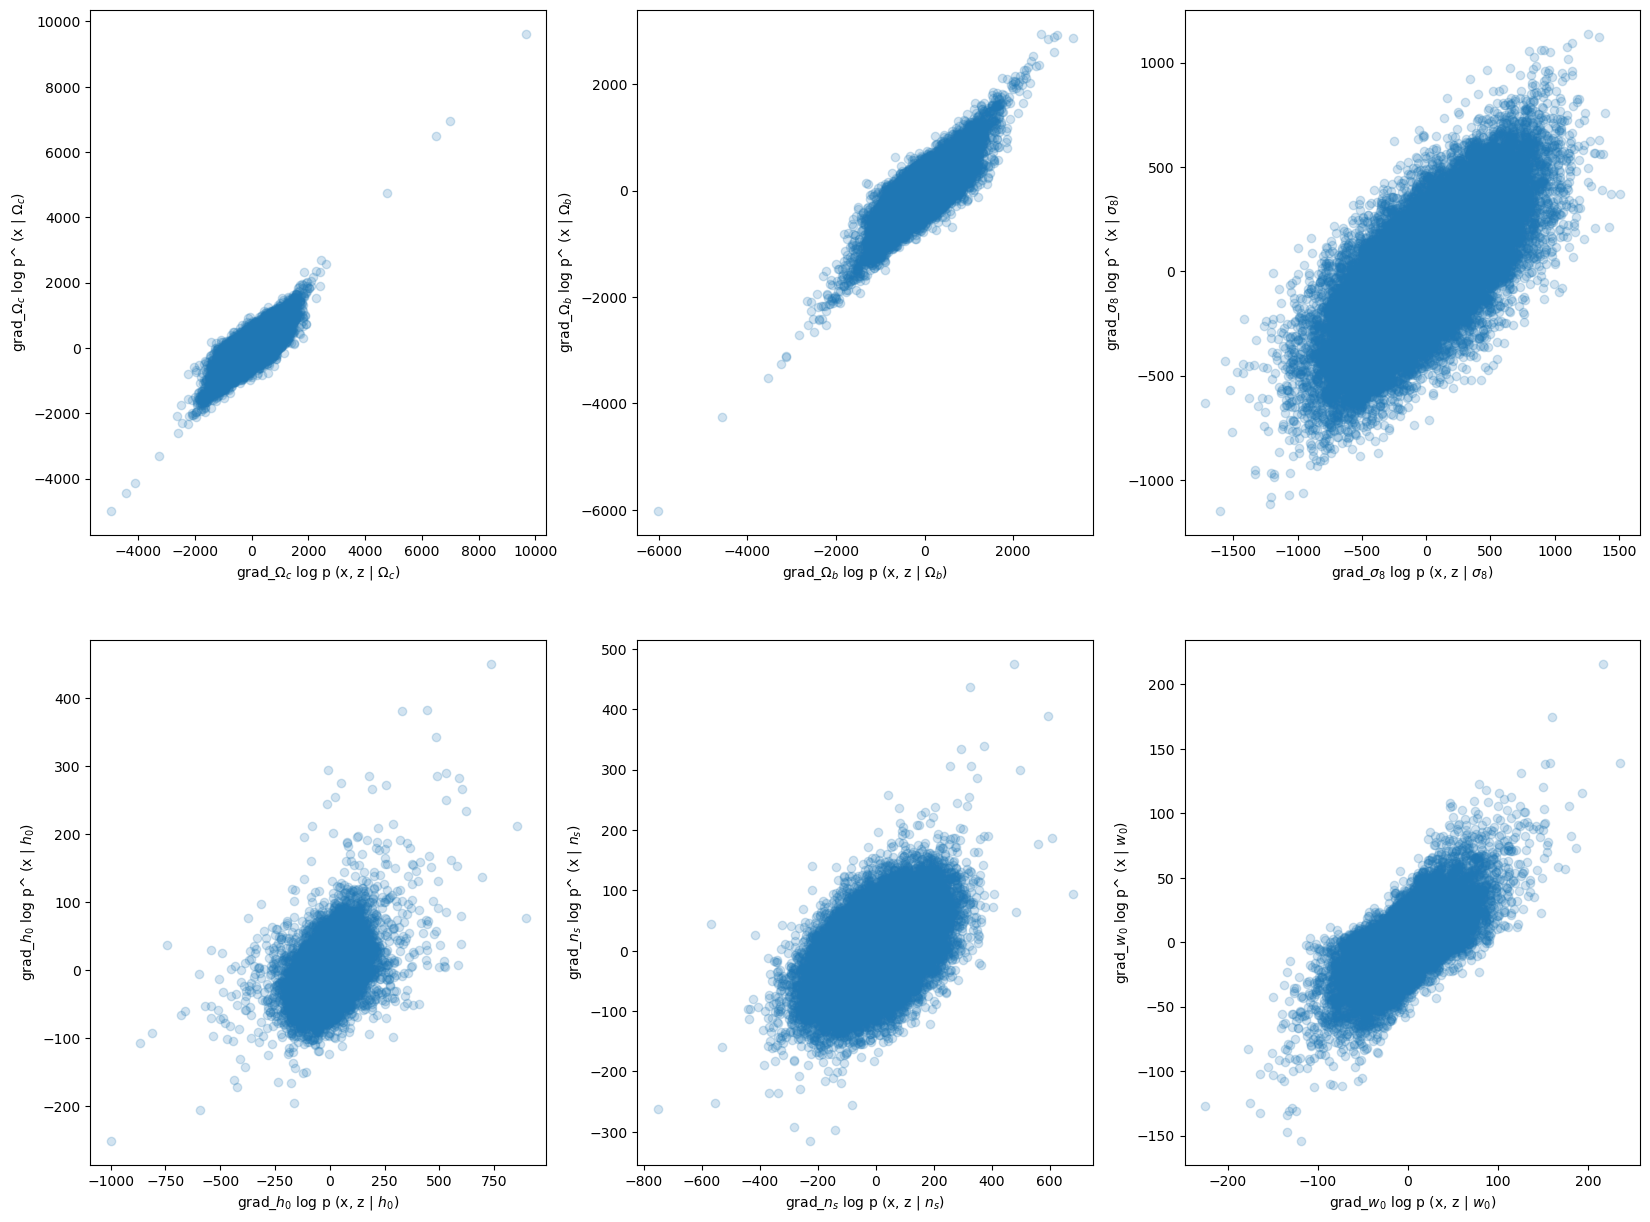

In [18]:
# check regression on train set

prediction = get_moments.apply(
    params_esperance,  
    dataset_theta_train,
    dataset_y_train
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_train[...,i], prediction[...,i], alpha = 0.2)
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression.png")

In [19]:
with open(
   "./SNR_study/params_esp.pkl", "wb"
) as fp:
    pickle.dump(params_esperance, fp)

# Predict std

In [20]:
@jax.jit
def loss_std(params,  theta, y, score):

    approx_esp = get_moments.apply(params_esperance, theta, y)
    approx_std = get_moments.apply(params, theta, y)
    approx_var = approx_std ** 2
    var = (approx_esp - score) ** 2

    return jnp.sum((var - approx_var) ** 2, axis=-1).mean() 


@jax.jit
def update_std(params, opt_state, theta, y, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_std)(
        params, theta, y, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [22]:
rng_seq = hk.PRNGSequence(10)
params_std = get_moments.init(next(rng_seq), jnp.zeros([1, 6]), jnp.zeros([1, 6]))

nb_steps = total_steps  - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-5,
    )

optimizer = optax.adam(lr_scheduler)
opt_state_std = optimizer.init(params_std)

batch_loss_std = []
val_loss_std = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
    inds = np.random.randint(0, len(dataset_score_test) - 1, batch_size)
    ex_score = dataset_score_test[inds]
    ex_theta = dataset_theta_test[inds]
    ex_y = dataset_y_test[inds]

    l, params_std, opt_state_std = update_std(
        params_std, opt_state_std, ex_theta, ex_y, ex_score
    )

    if batch % 500 == 0:
      batch_loss_std.append(l)
      val_loss_std.append(
          loss_std(
              params_std, 
              dataset_theta_train[inds], 
              dataset_y_train[inds],
              dataset_score_train[inds]
          )
      )
      lr_scheduler_store.append(lr_scheduler(batch))
      pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 383843696640.000: 100%|██████████| 500001/500001 [06:07<00:00, 1360.81it/s] 


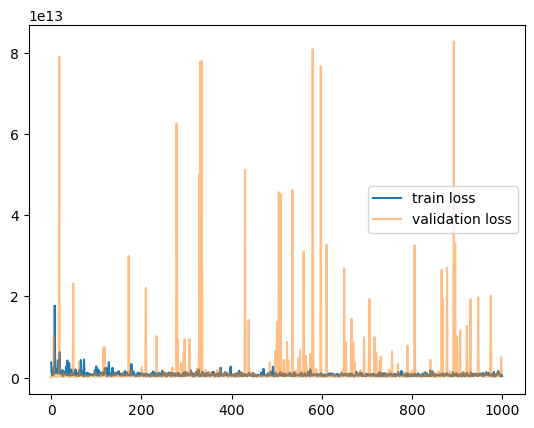

In [23]:
plt.plot(batch_loss_std, label = 'train loss')
plt.plot(val_loss_std, alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_std.png")

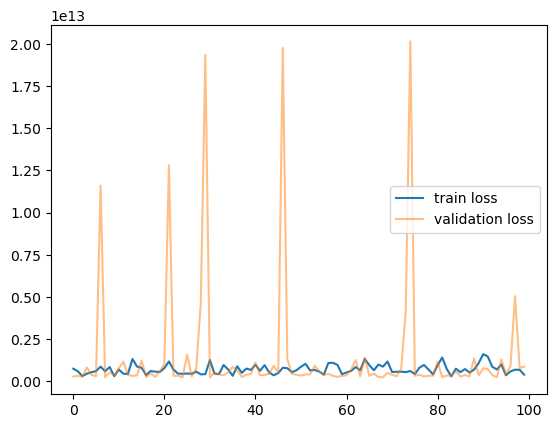

In [24]:
plt.plot(batch_loss_std[-100:], label = 'train loss')
plt.plot(val_loss_std[-100:], alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_std_zoom.png")

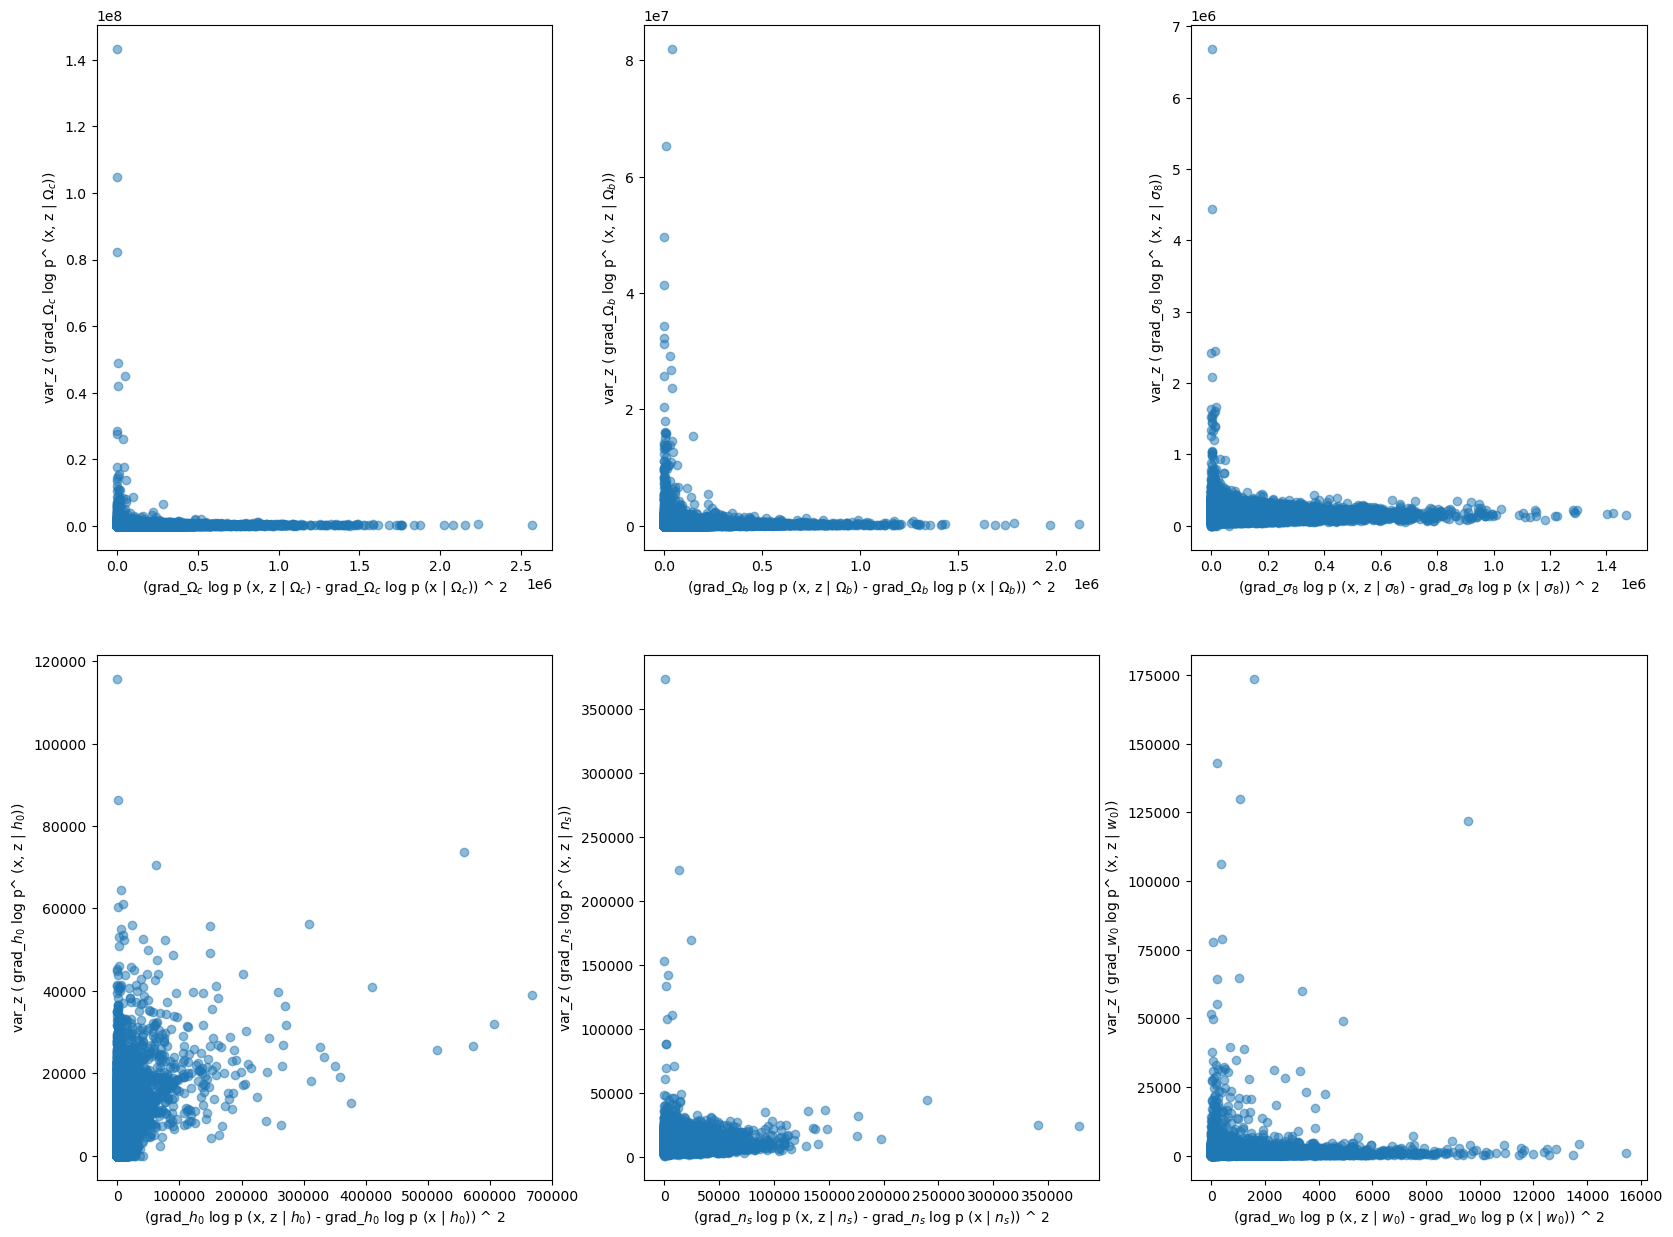

In [25]:
approx_esp = get_moments.apply(params_esperance, dataset_theta_train, dataset_y_train)

var = (approx_esp - dataset_score_train) ** 2

approx_std = get_moments.apply(params_std,  dataset_theta_train, dataset_y_train)
prediction = approx_std ** 2

plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var[...,i], prediction[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))

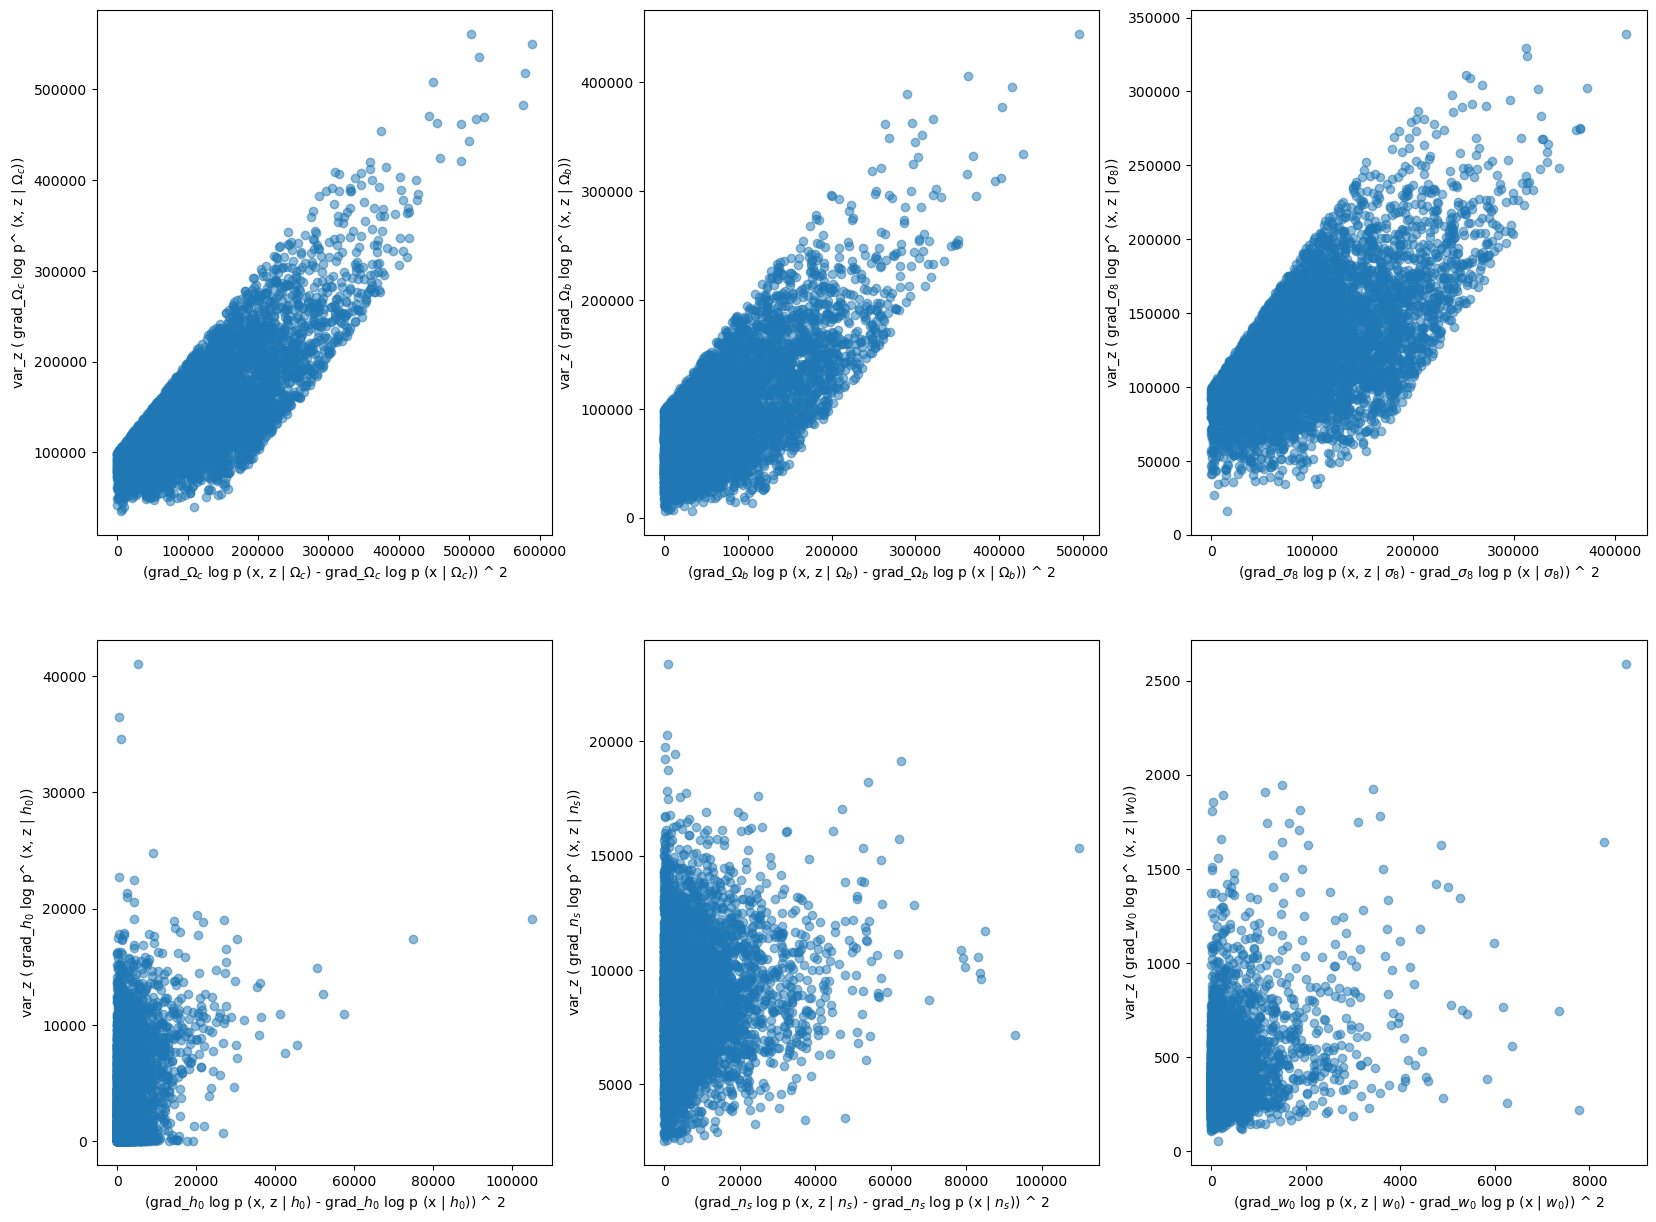

In [27]:
approx_esp = get_moments.apply(params_esperance, dataset_theta_train, dataset_y_train)

var = (approx_esp - dataset_score_train) ** 2

approx_std = get_moments.apply(params_std,  dataset_theta_train, dataset_y_train)
prediction = approx_std ** 2

inds = jnp.unique(jnp.where(jnp.abs(prediction - var) > 1e5)[0])

var_2 = jnp.delete(var, inds, axis = 0)
pred_2 = jnp.delete(prediction, inds, axis = 0)
    
plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var_2[...,i], pred_2[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))

# Compute SNR

In [37]:
def get_SNR(theta, x):
  esperance = get_moments.apply(params_esperance, theta, x)
  std = get_moments.apply(params_std, theta, x)
  return esperance / std ** 2

In [38]:
get_SNR(dataset_theta[-10:], dataset_y[-10:])

Array([[ 1.4597152e-03,  1.8240252e-03,  2.1990165e-03,  4.0397863e+00,
         6.7009013e-03, -1.9477533e-02],
       [ 1.8360578e-03,  2.2997707e-03,  1.9777350e-03,  3.2500981e-03,
         2.6223557e-03, -4.4768035e-02],
       [ 3.8760348e-04,  4.7974041e-04,  4.3691439e-04, -7.3680274e-02,
         1.1199713e-03, -3.2478382e-03],
       [ 4.2978462e-04,  4.2854907e-04,  7.3118671e-04,  1.0327465e-03,
         2.4451728e-03, -6.1542992e-03],
       [ 9.6767722e-04,  5.6783546e-04,  1.3644514e-03,  2.5100069e-02,
         5.0237142e-03, -1.0770212e-02],
       [-4.8728019e-04, -7.7503576e-04, -2.9928781e-04, -4.5276989e-04,
        -1.5443561e-03, -2.4805928e-03],
       [ 1.6953041e-03,  2.1872483e-03,  2.4734340e-03,  2.1286324e-02,
         7.1139378e-03, -1.1569497e-02],
       [ 7.2312838e-04,  1.7910943e-03,  4.4380201e-04,  1.6938831e-03,
         7.9078472e-04, -6.7183841e-03],
       [ 9.2069776e-04,  1.5563701e-03,  1.9672720e-03, -1.8506759e-03,
         1.9699445e-03, 

In [39]:
esperance = get_moments.apply(params_esperance, dataset_theta[-10:], dataset_y[-10:])
std = get_moments.apply(params_std, dataset_theta[-10:], dataset_y[-10:])

In [40]:
esperance

Array([[ 3.2246106e+02,  2.7306744e+02,  1.9658644e+02,  1.3634015e+01,
         4.1507694e+01, -1.1203038e+01],
       [ 3.8519098e+02,  3.7528912e+02,  2.3486316e+02,  4.8279161e+00,
         2.4433928e+01, -2.0982609e+01],
       [ 2.2127684e+02,  2.1812125e+02,  1.2884026e+02, -2.2349793e-01,
         2.0292793e+01, -8.3014126e+00],
       [ 1.4231882e+02,  1.3435516e+02,  1.4727176e+02,  8.4427204e+00,
         4.0542213e+01, -4.9945188e+00],
       [ 1.7085699e+02,  7.4147484e+01,  1.4320297e+02,  2.7707233e+01,
         4.1187687e+01, -4.3569460e+00],
       [-3.7834076e+01, -2.7986998e+01, -3.8924942e+01, -2.3156915e+00,
        -1.2661351e+01, -6.0178626e-01],
       [ 5.2178217e+02,  4.3966241e+02,  4.0577441e+02,  2.9038513e+01,
         7.0803818e+01, -1.7269033e+01],
       [ 7.6180260e+01,  5.2304173e+01,  9.8482460e+01,  1.6272224e+01,
         9.4694004e+00, -3.1232166e+00],
       [ 1.5388835e+02,  1.5529401e+02,  1.1880504e+02, -6.6749954e-01,
         8.1118879e+00, 

In [41]:
dataset_score[-10:]

array([[-105.36837  , -356.48538  , -270.69043  ,   27.896423 ,
          23.059677 ,    9.754538 ],
       [  12.406044 , -193.77557  , -251.45042  ,   39.748672 ,
          35.996895 ,  -16.011452 ],
       [ 236.87929  ,  198.29306  ,  173.6872   ,   12.964214 ,
          44.187244 ,  -19.082764 ],
       [ 104.77646  ,  186.93307  ,   84.69243  ,  -51.223267 ,
        -132.85619  ,   -6.556347 ],
       [ 804.6272   ,  617.5863   ,  638.5892   ,   40.877167 ,
          43.293144 ,  -13.995878 ],
       [ 380.7629   ,  389.95236  ,  327.12244  ,   -8.475769 ,
          35.047333 ,   12.185479 ],
       [-300.5276   , -272.22787  , -217.05838  ,  -12.6029625,
         -44.630943 ,   22.498167 ],
       [  -7.378427 ,   38.773643 ,  -97.64664  ,  -31.394073 ,
         -78.153725 ,   12.3643675],
       [-119.27785  ,  143.20071  ,  -68.34111  ,  -55.14219  ,
         -60.545082 ,    9.345825 ],
       [-667.78894  , -436.13794  , -591.5433   ,  -64.63228  ,
        -102.17309  ,   16.

In [42]:
std ** 2

Array([[2.20906828e+05, 1.49705969e+05, 8.93974375e+04, 3.37493467e+00,
        6.19434521e+03, 5.75177429e+02],
       [2.09792406e+05, 1.63185453e+05, 1.18753602e+05, 1.48546777e+03,
        9.31754883e+03, 4.68696228e+02],
       [5.70884562e+05, 4.54665156e+05, 2.94886719e+05, 3.03334832e+00,
        1.81190312e+04, 2.55598096e+03],
       [3.31139844e+05, 3.13511750e+05, 2.01414719e+05, 8.17501611e+03,
        1.65805117e+04, 8.11549561e+02],
       [1.76564031e+05, 1.30579164e+05, 1.04952781e+05, 1.10387085e+03,
        8.19865234e+03, 4.04536713e+02],
       [7.76433672e+04, 3.61105898e+04, 1.30058555e+05, 5.11450000e+03,
        8.19846582e+03, 2.42597763e+02],
       [3.07780875e+05, 2.01011656e+05, 1.64053062e+05, 1.36418640e+03,
        9.95283008e+03, 1.49263477e+03],
       [1.05348188e+05, 2.92023535e+04, 2.21906297e+05, 9.60646191e+03,
        1.19746875e+04, 4.64876190e+02],
       [1.67143188e+05, 9.97796172e+04, 6.03907539e+04, 3.60678772e+02,
        4.11782568e+03, 

In [43]:
std

Array([[-470.00726  ,  386.91855  ,  298.99405  ,    1.8370996,
         -78.70416  ,   23.982857 ],
       [-458.031    ,  403.9622   ,  344.60645  ,   38.541767 ,
         -96.52745  ,   21.649393 ],
       [-755.56903  ,  674.28864  ,  543.0347   ,   -1.741651 ,
        -134.60695  ,   50.55671  ],
       [-575.4475   ,  559.9212   ,  448.7925   ,   90.415794 ,
        -128.76534  ,   28.487709 ],
       [-420.19522  ,  361.3574   ,  323.96417  ,   33.224552 ,
         -90.54641  ,   20.113098 ],
       [-278.6456   ,  190.02786  ,  360.63632  ,   71.51573  ,
         -90.54538  ,   15.57555  ],
       [-554.78     ,  448.34323  ,  405.03464  ,  -36.934895 ,
         -99.76387  ,   38.634632 ],
       [-324.57385  ,  170.88696  ,  471.0693   ,   98.01256  ,
        -109.42892  ,   21.560987 ],
       [-408.83148  ,  315.87912  ,  245.7453   ,  -18.991545 ,
         -64.17029  ,   21.80675  ],
       [-392.21985  ,  302.99295  ,  269.7803   ,   -2.8374686,
         -70.49944  ,   20.

# Create new dataset with learned marginal score

In [135]:
# inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])

# dataset_y = jnp.delete(dataset.item()["y"], inds, axis=0)
# dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)
# dataset_theta = jnp.delete(dataset.item()["theta"], inds, axis=0)

# learned_marginal_score = get_moments.apply(params_esperance, dataset_score)
    
# dataset = {
#     'theta': dataset_theta, 
#     'score': learned_marginal_score, 
#     'y': dataset_y, 
# }

# # saving the dataset
# np.savez('LOADED&COMPRESSED_year_10_with_noise_score_conditional_marginal.npz', dataset)